In [86]:
%matplotlib inline
import csv
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import json
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
sns.set(style="darkgrid")
import gensim
from gensim.models import Phrases, KeyedVectors, Word2Vec
import gensim.downloader
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## Problem Introduction

We have a dataset in JSON format containing information about the user activity in a reddit forum **ROAP**. Our feature set comes from a bunch of user features noted at the time of posting user comments in the forun alogside the titel and text they chose. The response variable is whether the requester received the pizza or not.

## Basic data exploration

### 1. Loading the full dataset

In [2]:
with open('../data/random-acts-of-pizza/train.json') as f:
    train_json_data = json.load(f)

df = pd.io.json.json_normalize(train_json_data) 
df.head()

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,False,t3_l25d7,0,Hi I am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,...,False,[],0,1,0,1,None,nickylvst,1.317853e+09,1.317849e+09
1,N/A,2,5,False,t3_rcb83,0,I spent the last money I had on gas today. Im ...,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1.332652e+09,1.332649e+09
2,N/A,0,3,False,t3_lpu5j,0,My girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,...,False,[],0,3,0,3,None,jacquibatman7,1.319650e+09,1.319646e+09
3,N/A,0,1,True,t3_mxvj3,4,"It's cold, I'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,...,False,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,59,76,81,None,4on_the_floor,1.322855e+09,1.322855e+09
4,N/A,6,6,False,t3_1i6486,5,hey guys:\n I love this sub. I think it's grea...,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,...,False,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1225,1733,1887,None,Futuredogwalker,1.373658e+09,1.373654e+09


In [4]:
print('Total data rows in full training set: {}'.format(df.shape[0]))
print('Total data columns in full training set: {}'.format(df.shape[1]))

Total data rows in full training set: 4040
Total data columns in full training set: 32


### 2. Splitting training set into training and validation

As we don't have labeled test set, we have to split existing training data into training and validation set in order to evaluate our model performance. We have already split the train and validation in 90/10 ratio and saved as csv files. We read them directly in memory.

In [6]:
train = pd.read_csv("../prakhar/train.csv")
val = pd.read_csv("../prakhar/validation.csv")

In [7]:
print(train.shape)
print(val.shape)

(3636, 32)
(404, 32)


### 3. Extracting relevant columns (which are present in test data) 

In [5]:
relevant_cols = ['request_title', 'request_text_edit_aware' ,
                 'requester_number_of_posts_on_raop_at_request', 
                'requester_number_of_subreddits_at_request']

text_cols = ['request_title','request_text_edit_aware']

y_col = 'requester_received_pizza'

In [8]:
train = train[[y_col] + relevant_cols]
val = val[[y_col] + relevant_cols]

In [9]:
print(train.shape)
print(val.shape)

(3636, 5)
(404, 5)


### 4. Exploration of outcome variable (univariate)

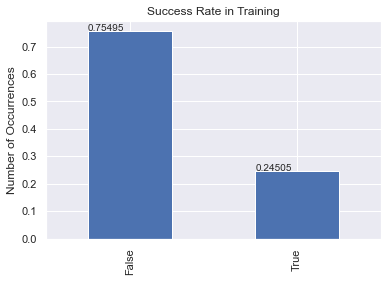

In [20]:
ax = train['requester_received_pizza'].value_counts(normalize=True).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 5)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Success Rate in Training')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

We see that there is a **24.5% success rate** in our training set. This is encouraging as although there is a class imbalance in our training dataset, it is not extream. 

### 5. Exploration of non-text features

#### 5.1 requester_number_of_posts_on_raop_at_request

It is evident that most of the requesters in our training set (95.25%) made their first post on RAOP when they requested for pizza. This strongly suggests a novelty effect at play if the training data is representative. When people discover this group and see others requesting pizza, they themselves are encouraged to ask for pizza from an unknown community.

In [21]:
train['requester_number_of_posts_on_raop_at_request'].value_counts()

0    3458
1     135
2      32
3       8
5       3
Name: requester_number_of_posts_on_raop_at_request, dtype: int64

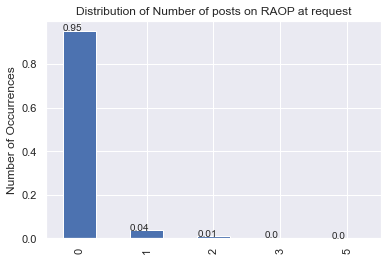

In [23]:
ax = train['requester_number_of_posts_on_raop_at_request'].value_counts(normalize=True).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Distribution of Number of posts on RAOP at request')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

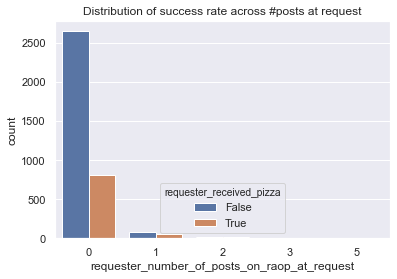

In [26]:
sns.countplot(x = 'requester_number_of_posts_on_raop_at_request', 
              hue='requester_received_pizza', data=train)
plt.title('Distribution of success rate across #posts at request')
pass

#### 5.2 requester_number_of_subreddits_at_request

We see the following pattern 

|Category|sub-reddits|count|Prcnt|
|--|--|--|--|
|New comer|0|656|18.04%|
|Newbie|1-5|730|20.07%|
|Somewhat Engaged|5-10|441|12.12%|
|Medium Engaged|10-50|1510|41.53%|
|Highly Engaged|50-100|267|7.34%|
|Power users|100+|32|0.88%|


This indicates that may be users are finding ROAP via freeform browsing and engaging when needed. Most of the users are existing users of reddit platform. 

In [27]:
pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+']).value_counts(normalize=True)

3. 10-50     0.415292
1. 1-5       0.200770
0. 0         0.180418
2. 5-10      0.121287
4. 50-100    0.073432
5. 100+      0.008801
Name: requester_number_of_subreddits_at_request, dtype: float64

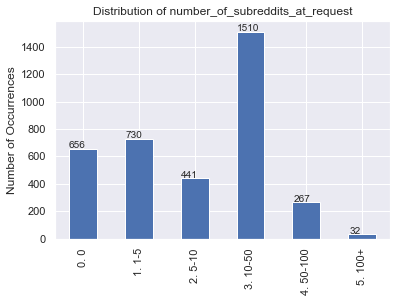

In [30]:
ax = pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+']).value_counts().sort_index().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Distribution of number_of_subreddits_at_request')
plt.ylabel('Number of Occurrences', fontsize=12)
pass

In [31]:
# creating the new feature
feat_train = pd.cut(train['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

feat_val = pd.cut(val['requester_number_of_subreddits_at_request'], 
       [-np.inf, 0, 5, 10, 50, 100, np.inf], 
       labels=['0. 0','1. 1-5', '2. 5-10', '3. 10-50', '4. 50-100', '5. 100+'])

train['num_subreddits_req'] = feat_train
val['num_subreddits_req'] = feat_val

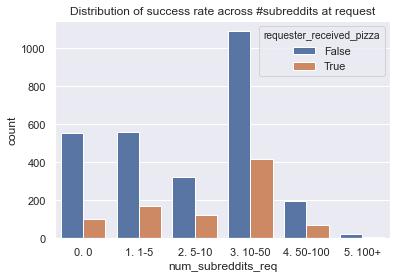

In [32]:
sns.countplot(x = 'num_subreddits_req', hue='requester_received_pizza', data=train)
plt.title('Distribution of success rate across #subreddits at request')
pass

### 6. Exploration of Text features

### PMI Calculation
The idea of PMI is that we want to quantify the likelihood of co-occurrence of two words, taking into account the fact that it might be caused by the frequency of the single words. Hence, the algorithm computes the (log) probability of co-occurrence scaled by the product of the single probability of occurrence as follows:


$$
PMI (a, b) = \log(\frac{P(a, b)}{P(a) * P(b)})
$$

Now, knowing that, when ‘a’ and ‘b’ are independent, their joint probability is equal to the product of their marginal probabilities, when the ratio equals 1 (hence the log equals 0), it means that the two words together don’t form a unique concept: they co-occur by chance.

It is important to note that we can use PMI criterion to not just detect the collocation of two words. We can also use it to get a sense of if a word and a class are co-occuring togather or not. This is the way we are going to use PMI in our case. 

#### 6.1 Feature Preprocessing 

The first step for text processing is to set up the preprocessing functions. In our preprocessing steps, we are doing the following:

1. Coverting the text to lower case
2. Removing stopwords
3. Removing digits
4. Lemmatizing the word tokens

In [76]:
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after",
                        "afterwards","again","against","ain't","all","allow","allows","almost","alone","along",
                        "already","also","although","always","am","among","amongst","an","and","another","any",
                        "anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear",
                        "appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated",
                        "at","available","away","awfully","b","be","became","because","become","becomes","becoming",
                        "been","before","beforehand","behind","being","believe","below","beside","besides","best",
                        "better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't",
                        "cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come",
                        "comes","concerning","consequently","consider","considering","contain","containing","contains",
                        "corresponding","could","couldn't","course","currently","d","definitely","described","despite",
                        "did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during",
                        "e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et",
                        "etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly",
                        "example","except","f","far","few","fifth","first","five","followed","following","follows",
                        "for","former","formerly","forth","four","from","further","furthermore","g","get","gets",
                        "getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had",
                        "hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello",
                        "help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself",
                        "hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll",
                        "i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate",
                        "indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd",
                        "it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l",
                        "last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked",
                        "likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean",
                        "meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n",
                        "name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless",
                        "new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel",
                        "now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones",
                        "only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside",
                        "over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus",
                        "possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really",
                        "reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same",
                        "saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems",
                        "seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she",
                        "should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime",
                        "sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub",
                        "such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx",
                        "that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's",
                        "thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll",
                        "they're","they've","think","third","this","thorough","thoroughly","those","though","three","through",
                        "throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly",
                        "try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up",
                        "upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via",
                        "viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome",
                        "well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's",
                        "whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither",
                        "who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without",
                        "won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've",
                        "your","yours","yourself","yourselves","z","zero"]}

stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

In [114]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    #print(text)
    #print('='*20)
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text))]

def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return ' '.join([word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()])

#### 6.2 Counting inclass and overall frequencies for all words in training dataset

The next step is to start with the pre-processed text and identify the occurance frequency for each token in the training and test dataset. 

In [113]:
def count_words_per_category(v, out):
    result_true, result_false, result_vocab = {}, {}, {}
    for ind, line in enumerate(v):
        #print(ind)
        #print(out[ind])
        if line != line:
            continue
        trf_line = preprocess_text(line) # preprocess and lammatized title text
        for elem in trf_line.split():
            result_vocab[elem] = result_vocab.get(elem, 0) + 1
            
            if out[ind]:
                result_true[elem] = result_true.get(elem, 0) + 1
            else: 
                result_false[elem] = result_false.get(elem, 0) + 1
    
    return result_true, result_false, result_vocab

#### 6.3 Implementing the PMI function

In the next step, we implement the PMI function and compute PMI for all the words in the dictionary

In [35]:
def pmi(inclass_freq, total_freq, class_freq, min_count=10):
    """
    inclass_freq (dict): dictionary containing inclass frequency for a given word
    total_freq (dict): dictionary containing total frequency for a given word
    class_freq (float): class prevalence
    min_count (int): minimum frequency for pmi calculation
    """
    pmi = {}
    for word, freq in total_freq.items():
        if freq < min_count:
            continue
        pmi[word] = np.log((inclass_freq.get(word, 0) + 0.001) * 1.0 / (class_freq * freq))
    return pmi

### 7. Feature Engineering

#### 7.1 non-text features

Looking at the data, there are just 2 text fields and a lot of non-text features present. We start with creating the non-text features first and then add text based features on top. 

In [59]:
# feature 1 - number of posts on ROAP at request

def num_posts_roap(data, colname, id_colname,th=0):
    """
    data (pandas dataframe): inout data frame
    colname (str): original column name
    id_colname (str): identifier for the created feature
    th (int): threshold for creating binary feature
    """
    new_colname = id_colname + '_' +colname
    feat = np.where(data[colname] == th, 0, 1)
    data[new_colname] = feat
    del data[colname]
    return data

In [60]:
train_final = train.copy()
val_final = val.copy()

In [61]:
train_final = num_posts_roap(data=train_final, 
                             colname='requester_number_of_posts_on_raop_at_request', 
                             id_colname='binary')

val_final = num_posts_roap(data=val_final, 
                             colname='requester_number_of_posts_on_raop_at_request', 
                             id_colname='binary')

In [62]:
# feature 2 - number subreddits dummy variables

def num_subreddit_dummy(data, colname):
    """
    data (pandas dataframe): inout data frame
    colname (str): original column name
    """
    return pd.get_dummies(data=data, columns=[colname], drop_first=True)

In [63]:
train_final = num_subreddit_dummy(data = train_final, colname='num_subreddits_req')
val_final = num_subreddit_dummy(data = val_final, colname='num_subreddits_req')

#### 7.2 Text feature extraction

We start by extacting the top 20 words from both text and title columns w.r.t. PMI criterion. For that we need to calculate the inclass frequencies and compute PMI as noted in above code. 

In [69]:
def get_counts(data, text_colname, outcome_colname):
    return count_words_per_category(data[text_colname], 
                                    list(data[outcome_colname]))

def get_top_k_from_dict(d, k):
    return sorted(d.items(), key=lambda kv: kv[1])[-k:]

def get_words(sorted_dict):
    return [w[0] for w in sorted_dict]

def calculate_pmi(data, text_colname, outcome_colname, class_freq_true, top_k):
    count_class_true, count_class_false, count_total = get_counts(data = data, 
                                                         text_colname=text_colname, 
                                                         outcome_colname=outcome_colname) 
    pmi_true = pmi(inclass_freq=count_class_true, 
                   total_freq=count_total, 
                   class_freq=class_freq_true)
    
    pmi_false = pmi(inclass_freq=count_class_false, 
                   total_freq=count_total, 
                   class_freq=1-class_freq_true)
    
    pmi_true_top_k = get_top_k_from_dict(pmi_true, k=top_k)
    pmi_false_top_k = get_top_k_from_dict(pmi_false, k=top_k)
    
    pmi_true_words = get_words(pmi_true_top_k)
    pmi_false_words = get_words(pmi_false_top_k)
    
    return pmi_true_words, pmi_false_words


In [116]:
true_class_pmi_words_title, false_class_pmi_words_title = calculate_pmi(data = train_final, 
                                                                        text_colname='request_title', 
                                                                        outcome_colname='requester_received_pizza', 
                                                                        class_freq_true=0.24505, 
                                                                        top_k=20)

In [115]:
true_class_pmi_words_text, false_class_pmi_words_text = calculate_pmi(data = train_final, 
                                                                      text_colname='request_text_edit_aware', 
                                                                      outcome_colname='requester_received_pizza', 
                                                                      class_freq_true=0.24505, 
                                                                      top_k=20)

In [123]:
# Creating text features - token counts
def simple_token_count(v):
    result = []
    for line in v:
        if line != line:
            result.append(1)
            continue
        result.append(len(word_tokenize(line)))
    return result

In [124]:
title_length_train = simple_token_count(train_final.request_title)
title_length_val = simple_token_count(val_final.request_title)
text_length_train = simple_token_count(train_final.request_text_edit_aware)
text_length_val = simple_token_count(val_final.request_text_edit_aware)

In [125]:
train_final['title_length'] = title_length_train
train_final['text_length'] = text_length_train
val_final['title_length'] = title_length_val
val_final['text_length'] = text_length_val

In [126]:
train_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_subreddits_req_4. 50-100',
       'num_subreddits_req_5. 100+', 'title_length', 'text_length'],
      dtype='object')

In [127]:
val_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_subreddits_req_4. 50-100',
       'num_subreddits_req_5. 100+', 'title_length', 'text_length'],
      dtype='object')

In [128]:
## Advanced word matching features

w_vect = gensim.downloader.load('glove-twitter-50')

def get_binary_feature(word, vector, wv):
    result = []
    candidates = set([w[0] for w in wv.most_similar(word, topn=20)] + [word])
    for line in vector:
        if line != line:
            result.append(0)
            continue
        trf_line = preprocess_text(line)
        if len(candidates.intersection(set(trf_line))) > 0:
            result.append(1)
        else:
            result.append(0)
    return result

def text_feature_addition(word_list, df, colname, id_str, wv):
    for ind, word in enumerate(word_list):
        print(ind, ' : ', word)
        f_name = id_str + word
        feat = get_binary_feature(word, df[colname], wv)
        df[f_name] = feat
    return df

In [129]:
train_final = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=train_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

train_final = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=train_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

train_final = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=train_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

train_final = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=train_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  username
1  :  exhaust
2  :  economy
3  :  bunch
4  :  smoke
5  :  yup
6  :  drunk
7  :  uh
8  :  build
9  :  atlanta
10  :  ta
11  :  bc
12  :  dc
13  :  english
14  :  toronto
15  :  everyday
16  :  bedroom
17  :  needless
18  :  fancy
19  :  ga
0  :  puppy
1  :  weird
2  :  dvd
3  :  update
4  :  gluten
5  :  stone
6  :  exchange
7  :  delete
8  :  partner
9  :  fly
10  :  needy
11  :  fry
12  :  individual
13  :  basic
14  :  package
15  :  admit
16  :  subsist
17  :  kidney
18  :  lawyer
19  :  bonus
0  :  tire
1  :  final
2  :  play
3  :  fuck
4  :  parent
5  :  slice
6  :  jersey
7  :  study
8  :  toronto
9  :  order
10  :  noodle
11  :  enjoy
12  :  london
13  :  na
14  :  pepperoni
15  :  wan
16  :  class
17  :  houston
18  :  test
19  :  forget
0  :  late
1  :  raop
2  :  dallas
3  :  rough
4  :  lonely
5  :  happy
6  :  lay
7  :  daughter
8  :  nj
9  :  yesterday
10  :  father
11  :  iowa
12  :  forever
13  :  gas
14  :  arizona
15  :  anniversary
16  :  mo
17  :  red


In [130]:
val_final = text_feature_addition(word_list=false_class_pmi_words_text, 
                                    df=val_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_false_')

val_final = text_feature_addition(word_list=true_class_pmi_words_text, 
                                    df=val_final, 
                                    colname='request_text_edit_aware', 
                                    wv=w_vect, 
                                    id_str='text_true_')

val_final = text_feature_addition(word_list=false_class_pmi_words_title, 
                                    df=val_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_false_')

val_final = text_feature_addition(word_list=true_class_pmi_words_title, 
                                    df=val_final, 
                                    colname='request_title', 
                                    wv=w_vect, 
                                    id_str='title_true_')

0  :  username
1  :  exhaust
2  :  economy
3  :  bunch
4  :  smoke
5  :  yup
6  :  drunk
7  :  uh
8  :  build
9  :  atlanta
10  :  ta
11  :  bc
12  :  dc
13  :  english
14  :  toronto
15  :  everyday
16  :  bedroom
17  :  needless
18  :  fancy
19  :  ga
0  :  puppy
1  :  weird
2  :  dvd
3  :  update
4  :  gluten
5  :  stone
6  :  exchange
7  :  delete
8  :  partner
9  :  fly
10  :  needy
11  :  fry
12  :  individual
13  :  basic
14  :  package
15  :  admit
16  :  subsist
17  :  kidney
18  :  lawyer
19  :  bonus
0  :  tire
1  :  final
2  :  play
3  :  fuck
4  :  parent
5  :  slice
6  :  jersey
7  :  study
8  :  toronto
9  :  order
10  :  noodle
11  :  enjoy
12  :  london
13  :  na
14  :  pepperoni
15  :  wan
16  :  class
17  :  houston
18  :  test
19  :  forget
0  :  late
1  :  raop
2  :  dallas
3  :  rough
4  :  lonely
5  :  happy
6  :  lay
7  :  daughter
8  :  nj
9  :  yesterday
10  :  father
11  :  iowa
12  :  forever
13  :  gas
14  :  arizona
15  :  anniversary
16  :  mo
17  :  red


In [131]:
train_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_subreddits_req_4. 50-100',
       'num_subreddits_req_5. 100+', 'title_length', 'text_length',
       'text_false_username', 'text_false_exhaust', 'text_false_economy',
       'text_false_bunch', 'text_false_smoke', 'text_false_yup',
       'text_false_drunk', 'text_false_uh', 'text_false_build',
       'text_false_atlanta', 'text_false_ta', 'text_false_bc', 'text_false_dc',
       'text_false_english', 'text_false_toronto', 'text_false_everyday',
       'text_false_bedroom', 'text_false_needless', 'text_false_fancy',
       'text_false_ga', 'text_true_puppy', 'text_true_weird', 'text_true_dvd',
       'text_true_update', 'text_true_gluten', 'text_true_stone',
       'text_true_exchange', 

In [132]:
val_final.columns

Index(['requester_received_pizza', 'request_title', 'request_text_edit_aware',
       'requester_number_of_subreddits_at_request',
       'binary_requester_number_of_posts_on_raop_at_request',
       'num_subreddits_req_1. 1-5', 'num_subreddits_req_2. 5-10',
       'num_subreddits_req_3. 10-50', 'num_subreddits_req_4. 50-100',
       'num_subreddits_req_5. 100+', 'title_length', 'text_length',
       'text_false_username', 'text_false_exhaust', 'text_false_economy',
       'text_false_bunch', 'text_false_smoke', 'text_false_yup',
       'text_false_drunk', 'text_false_uh', 'text_false_build',
       'text_false_atlanta', 'text_false_ta', 'text_false_bc', 'text_false_dc',
       'text_false_english', 'text_false_toronto', 'text_false_everyday',
       'text_false_bedroom', 'text_false_needless', 'text_false_fancy',
       'text_false_ga', 'text_true_puppy', 'text_true_weird', 'text_true_dvd',
       'text_true_update', 'text_true_gluten', 'text_true_stone',
       'text_true_exchange', 

### 8. Model training and baseline results

In [133]:
Xcols = [c for c in train_final.columns.tolist() if c not in train.columns.tolist()[:3]]

In [135]:
# Hyper parameter tuning

# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(1, 10, 1)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'log2', 8, 10, 15, 20]

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(4, 10, 7)]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

rf_class_weight = [None, 'balanced', 'balanced_subsample']

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
            'max_depth': rf_max_depth,
            'max_features': rf_max_features,
            'min_samples_split': rf_min_samples_split,
            'bootstrap': rf_bootstrap, 
            'class_weight': rf_class_weight}

rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 2000, cv = 5, verbose = 1, random_state = 42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(train_final[Xcols], train_final[y_col])

# View the best parameters from the random search
rf_random.best_params_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 57.6min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000

{'n_estimators': 400,
 'min_samples_split': 8,
 'max_features': 20,
 'max_depth': 1,
 'class_weight': None,
 'bootstrap': True}

#### 8.2 Final model fitting 

In [136]:
rf_final = RandomForestClassifier(n_estimators=400, min_samples_split=8, max_features=20, 
                                  max_depth=1, class_weight=None,
                                 bootstrap=True, n_jobs=-1, random_state=42)

rf_final.fit(train_final[Xcols], train_final[y_col])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=1, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### 8.3 Model predictions

In [137]:
prediction_probs = rf_final.predict_proba(val_final[Xcols])[:,1]

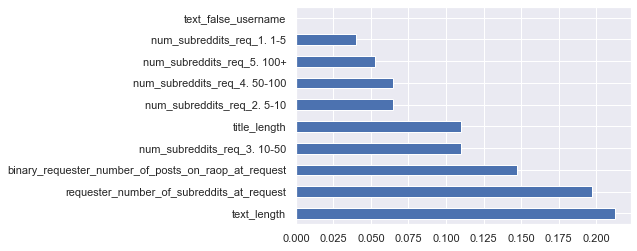

In [139]:
feat_importances = pd.Series(rf_final.feature_importances_, index=Xcols)
feat_importances.nlargest(10).plot(kind='barh')
pass

#### 8.4 Choosing right thresholds and reporting results

Best Threshold=0.239164, F-Score=0.430


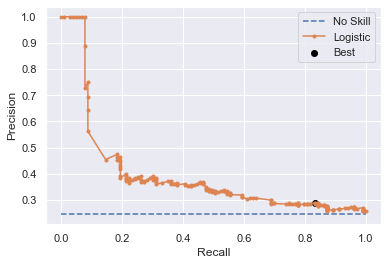

In [140]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(val_final[y_col], prediction_probs)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = 0.24505
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [141]:
pred_lable = prediction_probs>=0.239164

In [142]:
print(classification_report(y_true=val_final[y_col], y_pred=pred_lable))

              precision    recall  f1-score   support

       False       0.84      0.30      0.44       301
        True       0.29      0.83      0.43       103

    accuracy                           0.44       404
   macro avg       0.57      0.57      0.44       404
weighted avg       0.70      0.44      0.44       404

